In [1]:
import os
import cv2
import numpy as np
from decomposition.AGF_decomposition import agf_decomposition


def extract_base_images(
    folder_path,
    folder_out_path,
    start,
    end,
    sigma_spatial=5,
    sigma_range=0.05,
    iterations=4,
    median_ksize=3,
    numba=True
):
    os.makedirs(folder_out_path, exist_ok=True)

    valid_exts = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')

    # Lấy danh sách ảnh và sort
    img_list = sorted([
        f for f in os.listdir(folder_path)
        if f.lower().endswith(valid_exts)
    ])

    # Cắt theo index
    img_list = img_list[start:end]

    print(f"🔹 Processing {len(img_list)} images from index {start} to {end}")

    for fname in img_list:
        img_path = os.path.join(folder_path, fname)

        # Đọc ảnh grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"⚠️ Cannot read image: {fname}")
            continue

        # Chuẩn hóa về [0, 1]
        img = img.astype(np.float32) / 255.0

        # AGF decomposition
        base, _ = agf_decomposition(
            img,
            sigma_spatial=sigma_spatial,
            sigma_range=sigma_range,
            iterations=iterations,
            median_ksize=median_ksize,
            numba=numba
        )

        # Clamp + chuyển về uint8
        base = np.clip(base, 0, 1)
        base_uint8 = (base * 255).astype(np.uint8)

        # Lưu ảnh
        out_path = os.path.join(folder_out_path, fname)
        cv2.imwrite(out_path, base_uint8)

    print("✅ Done extracting base components")

folder_path = "C://Users//ADMIN//OneDrive - Hanoi University of Science and Technology//Desktop//Medical Image Fusion//MSRS//train//ir"
folder_out_path = "C://Users//ADMIN//OneDrive - Hanoi University of Science and Technology//Desktop//AGF_IVIF//data//training_model//train//ir_base"

extract_base_images(
    folder_path=folder_path,
    folder_out_path=folder_out_path,
    start=100,
    end=850
)

🔹 Processing 750 images from index 100 to 850
✅ Done extracting base components


In [3]:
import os
import cv2
import numpy as np
from decomposition.AGF_decomposition import agf_decomposition


def extract_base_images(
    folder_path,
    folder_out_path,
    start,
    end,
    sigma_spatial=5,
    sigma_range=0.05,
    iterations=4,
    median_ksize=3,
    numba=True
):
    os.makedirs(folder_out_path, exist_ok=True)

    valid_exts = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')

    # Lấy danh sách ảnh và sort
    img_list = sorted([
        f for f in os.listdir(folder_path)
        if f.lower().endswith(valid_exts)
    ])

    # Cắt theo index
    img_list = img_list[start:end]

    print(f"🔹 Processing {len(img_list)} images from index {start} to {end}")

    for fname in img_list:
        img_path = os.path.join(folder_path, fname)

        # Đọc ảnh grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"⚠️ Cannot read image: {fname}")
            continue

        # Chuẩn hóa về [0, 1]
        img = img.astype(np.float32) / 255.0

        # AGF decomposition
        base, _ = agf_decomposition(
            img,
            sigma_spatial=sigma_spatial,
            sigma_range=sigma_range,
            iterations=iterations,
            median_ksize=median_ksize,
            numba=numba
        )

        # Clamp + chuyển về uint8
        base = np.clip(base, 0, 1)
        base_uint8 = (base * 255).astype(np.uint8)

        # Lưu ảnh
        out_path = os.path.join(folder_out_path, fname)
        cv2.imwrite(out_path, base_uint8)

    print("✅ Done extracting base components")

folder_path = "C://Users//ADMIN//OneDrive - Hanoi University of Science and Technology//Desktop//Medical Image Fusion//MSRS//train//vi_Y"
folder_out_path = "C://Users//ADMIN//OneDrive - Hanoi University of Science and Technology//Desktop//AGF_IVIF//data//training_model//valid//vi_base"

extract_base_images(
    folder_path=folder_path,
    folder_out_path=folder_out_path,
    start=851,
    end=1082
)

🔹 Processing 231 images from index 851 to 1082
✅ Done extracting base components


#### Decomposition 

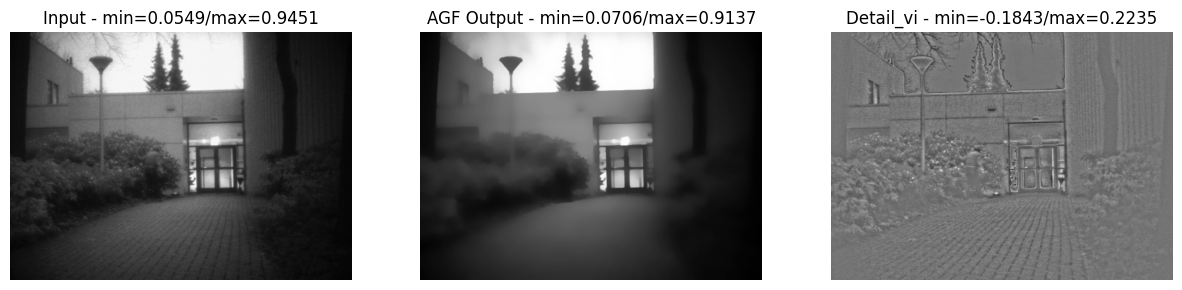

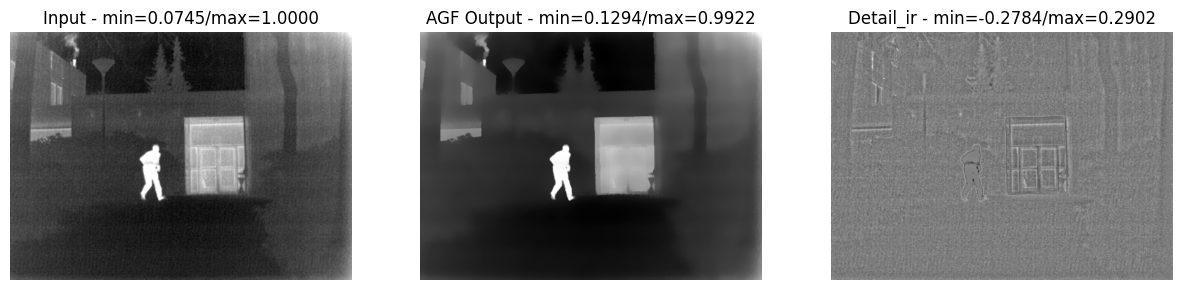

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from decomposition.AGF_decomposition import agf_decomposition

# Decompose the visible image
img_vi = cv2.imread(".\\data\\TNO\\vi\\17.png", cv2.IMREAD_GRAYSCALE)
img_vi = img_vi.astype(np.float32) / 255.0

base_vi, detail_vi = agf_decomposition(
    img_vi,
    sigma_spatial=5,
    sigma_range=0.05,
    iterations=4,
    median_ksize=3,
    numba=True
)

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1); plt.title(f"Input - min={img_vi.min():.4f}/max={img_vi.max():.4f}"); plt.imshow(img_vi, cmap="gray"); plt.axis("off")
plt.subplot(1,3,2); plt.title(f"AGF Output - min={base_vi.min():.4f}/max={base_vi.max():.4f}"); plt.imshow(base_vi, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title(f"Detail_vi - min={detail_vi.min():.4f}/max={detail_vi.max():.4f}"); plt.imshow(detail_vi, cmap="gray"); plt.axis("off")
plt.show()

# Decompose the infrared image
img_ir = cv2.imread(".\\data\\TNO\\ir\\17.png", cv2.IMREAD_GRAYSCALE)
img_ir = img_ir.astype(np.float32) / 255.0  

base_ir, detail_ir = agf_decomposition(
    img_ir,
    sigma_spatial=5,
    sigma_range=0.05,
    iterations=4,
    median_ksize=3,
    numba=True
)

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1); plt.title(f"Input - min={img_ir.min():.4f}/max={img_ir.max():.4f}"); plt.imshow(img_ir, cmap="gray"); plt.axis("off")
plt.subplot(1,3,2); plt.title(f"AGF Output - min={base_ir.min():.4f}/max={base_ir.max():.4f}"); plt.imshow(base_ir, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title(f"Detail_ir - min={detail_ir.min():.4f}/max={detail_ir.max():.4f}"); plt.imshow(detail_ir, cmap="gray"); plt.axis("off")
plt.show()

In [2]:
restruct_vi = base_vi + detail_vi
restruct_ir = base_ir + detail_ir

# Tính PSNR giữa ảnh gốc và ảnh tái cấu trúc
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

psnr_vi = psnr(img_vi, restruct_vi)
psnr_ir = psnr(img_ir, restruct_ir)
print(f"PSNR between original and reconstructed visible image: {psnr_vi:.2f} dB")
print(f"PSNR between original and reconstructed infrared image: {psnr_ir:.2f} dB")

PSNR between original and reconstructed visible image: inf dB
PSNR between original and reconstructed infrared image: inf dB


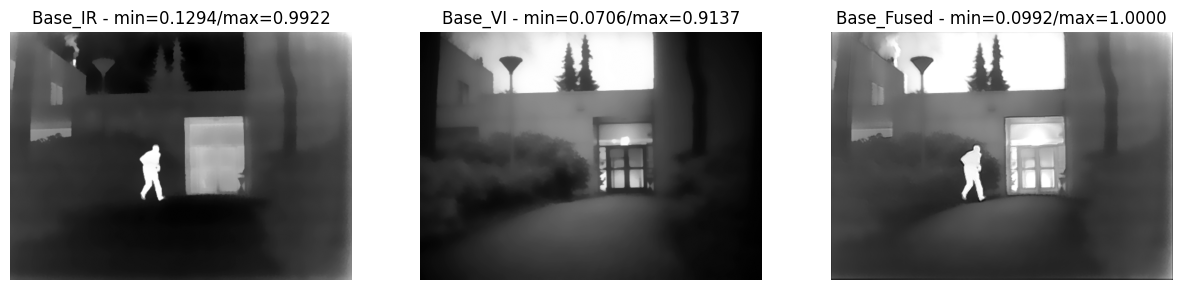

In [10]:
from base_fusion.base_fused import fuse_ir_vi_numpy

base_fused = fuse_ir_vi_numpy(
    ir_base=base_ir,
    vi_base=base_vi,
    model_path="F://AGF_IVIF//base_fusion//run//train_2//best_model.pth",
    device="cpu"
)

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1); plt.title(f"Base_IR - min={base_ir.min():.4f}/max={base_ir.max():.4f}"); plt.imshow(base_ir, cmap="gray"); plt.axis("off")
plt.subplot(1,3,2); plt.title(f"Base_VI - min={base_vi.min():.4f}/max={base_vi.max():.4f}"); plt.imshow(base_vi, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title(f"Base_Fused - min={base_fused.min():.4f}/max={base_fused.max():.4f}"); plt.imshow(base_fused, cmap="gray"); plt.axis("off")
plt.show()


#### Detail Fusion

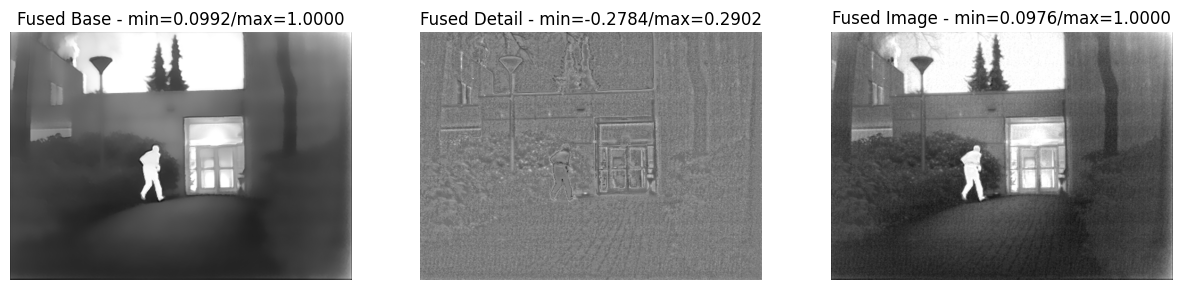

In [7]:
from detail_fusion.MVA_WLE import fuse_detail_dynamic_WLE_im2col_var_optimizer

# base_fused = np.maximum(base_vi, base_ir)
detail_fulsed = fuse_detail_dynamic_WLE_im2col_var_optimizer(detail_ir, detail_vi)
fused = np.clip(base_fused + detail_fulsed, 0, 1)

cv2.imwrite(".\\data\\output\\AGF_fusion_base.png", (fused * 255).astype(np.uint8))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.title(f"Fused Base - min={base_fused.min():.4f}/max={base_fused.max():.4f}"); plt.imshow(base_fused, cmap="gray"); plt.axis("off")
plt.subplot(1,3,2); plt.title(f"Fused Detail - min={detail_fulsed.min():.4f}/max={detail_fulsed.max():.4f}"); plt.imshow(detail_fulsed, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title(f"Fused Image - min={fused.min():.4f}/max={fused.max():.4f}"); plt.imshow(fused, cmap="gray"); plt.axis("off")
plt.show()

In [8]:
import pandas as pd
from metric.eval_one_image import evaluation_one

ir_image = ".\\data\\TNO\\ir\\17.png"
vi_image = ".\\data\\TNO\\vi\\17.png"
fused_image = ".\\data\\output\\AGF_fusion_base.png"

EN, MI, SF, AG, SD, MLI, CC, SCD, VIF, MSE, PSNR, Qabf, Nabf, SSIM, MS_SSIM = evaluation_one(ir_image, vi_image, fused_image)

# Tạo bảng kết quả
data = {
    "Metric": [
        "EN", "MI", "SF", "AG", "SD", "MLI", "CC", "SCD",
        "VIF", "MSE", "PSNR", "Qabf", "Nabf", "SSIM", "MS_SSIM"
    ],
    "Value": [
        EN, MI, SF, AG, SD, MLI, CC, SCD,
        VIF, MSE, PSNR, Qabf, Nabf, SSIM, MS_SSIM
    ]
}

df = pd.DataFrame(data)

# Làm tròn cho đẹp (tuỳ chọn)
df["Value"] = df["Value"].round(6)

# Hiển thị bảng
print(df)


torch.Size([1, 1, 1, 450, 620]) torch.Size([1, 1, 1, 450, 620])
torch.Size([1, 1, 1, 450, 620]) torch.Size([1, 1, 1, 450, 620])
     Metric       Value
0        EN    7.071723
1        MI    3.001271
2        SF   10.304983
3        AG    3.992532
4        SD   58.135594
5       MLI  118.053345
6        CC    0.555643
7       SCD    1.771703
8       VIF    0.694899
9       MSE    0.057249
10     PSNR   60.553109
11     Qabf    0.549567
12     Nabf    0.042701
13     SSIM    0.460123
14  MS_SSIM    0.485458


#### Base Fusion

In [ ]:
import torch
import cv2
import numpy as np
from base_fusion.loss.loss import fusion_loss_vif

def load_gray_image(path, device):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Cannot load image: {path}")

    img = img.astype(np.float32) / 255.0
    img = torch.from_numpy(img).unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
    return img.to(device)


def compute_fusion_loss(image1_path, image2_path, image_fused_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load images
    image_A = load_gray_image(image1_path, device)
    image_B = load_gray_image(image2_path, device)
    image_F = load_gray_image(image_fused_path, device)

    # Init loss
    criterion = fusion_loss_vif().to(device)

    # Compute loss
    fusion_loss, loss_grad, loss_l1, loss_ssim = criterion(
        image_A, image_B, image_F
    )

    return {
        "fusion_loss": fusion_loss.item(),
        "loss_gradient": loss_grad.item(),
        "loss_intensity": loss_l1.item(),
        "loss_ssim": loss_ssim.item(),
        "device": str(device)
    }


if __name__ == "__main__":
    image1_path = ".\\data\\TNO\\ir\\17.png"
    image2_path = ".\\data\\TNO\\vi\\17.png"
    image_fused_path = ".\\data\\output\\AGF_fusion_base.png"

    loss_dict = compute_fusion_loss(
        image1_path, image2_path, image_fused_path
    )

    for k, v in loss_dict.items():
        print(f"{k}: {v}")


fusion_loss: 3.6317129135131836
loss_gradient: 0.7227263450622559
loss_intensity: 0.16194561123847961
loss_ssim: 2.7470409870147705
device: cpu


#### Full Pipeline

In [ ]:
import numpy as np
import torch
import cv2

from base_fusion.model.convnext_fusion_net_ver1 import ConvNeXtFusionNetVer1


def numpy_to_tensor(img_np):
    """
    img_np: (H,W) or (H,W,1)
    return: torch.Tensor (1,1,H,W), float32 [0,1]
    """
    if img_np.ndim == 3:
        img_np = img_np.squeeze(-1)

    img_np = img_np.astype(np.float32)

    if img_np.max() > 1.0:
        img_np /= 255.0

    tensor = torch.from_numpy(img_np).unsqueeze(0).unsqueeze(0)
    return tensor

@torch.no_grad()
def fuse_ir_vi_numpy(
    ir_base: np.ndarray,
    vi_base: np.ndarray,
    model_path: str,
    device: str = "cuda"
) -> np.ndarray:
    """
    IR–VI fusion inference
    """

    # ==========================
    # Load model
    # ==========================
    model = ConvNeXtFusionNetVer1().to(device)
    model.load_state_dict(
        torch.load(model_path, map_location=device)
    )
    model.eval()

    # ==========================
    # Preprocess
    # ==========================
    ir = numpy_to_tensor(ir_base).to(device)
    vi = numpy_to_tensor(vi_base).to(device)

    # ==========================
    # Forward
    # ==========================
    fused = model(ir, vi)

    # ==========================
    # Postprocess
    # ==========================
    fused = torch.clamp(fused, 0.0, 1.0)
    fused_np = fused.squeeze().cpu().numpy().astype(np.float32)

    return fused_np

# if __name__ == "__main__":
#     ir = cv2.imread("ir.png", cv2.IMREAD_GRAYSCALE)
#     vi = cv2.imread("vi.png", cv2.IMREAD_GRAYSCALE)

#     fused = fuse_ir_vi_numpy(
#         ir_base=ir,
#         vi_base=vi,
#         model_path="path/to/best_model.pth",
#         device="cuda"
#     )

#     cv2.imwrite("fused.png", (fused * 255).astype("uint8"))


In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from decomposition.AGF_decomposition import agf_decomposition
# from base_fusion.base_fused import fuse_ir_vi_numpy
from detail_fusion.MVA_WLE import fuse_detail_dynamic_WLE_im2col_var_optimizer

for i in range(42):
    number_image = i + 1
    if number_image < 10:
        code_image = '0'+str(number_image)
    else:
        code_image = str(number_image)

    # Decompose image
    img_vi = cv2.imread(f".\\data\\TNO\\vi\\{code_image}.png", cv2.IMREAD_GRAYSCALE)
    img_vi = img_vi.astype(np.float32) / 255.0
    img_ir = cv2.imread(f".\\data\\TNO\\ir\\{code_image}.png", cv2.IMREAD_GRAYSCALE)
    img_ir = img_ir.astype(np.float32) / 255.0  

    base_vi, detail_vi = agf_decomposition(
        img_vi,
        sigma_spatial=5,
        sigma_range=0.05,
        iterations=4,
        median_ksize=3,
        numba=True
    )

    base_ir, detail_ir = agf_decomposition(
        img_ir,
        sigma_spatial=5,
        sigma_range=0.05,
        iterations=4,
        median_ksize=3,
        numba=True
    )

    base_fused = fuse_ir_vi_numpy(
        ir_base=base_ir,
        vi_base=base_vi,
        model_path="F://AGF_IVIF//base_fusion//run//train_3//best_model.pth",
        device="cpu"
    )

    detail_fulsed = fuse_detail_dynamic_WLE_im2col_var_optimizer(detail_ir, detail_vi)

    fused = np.clip(base_fused + detail_fulsed, 0, 1)

    cv2.imwrite(f".\\data\\output\\train_3_ver_1\\{code_image}.png", (fused * 255).astype(np.uint8))


In [30]:
import pandas as pd
from metric.eval_one_image import evaluation_one

# Danh sách lưu kết quả từng ảnh
results = []

num_images = 42

for i in range(num_images):
    number_image = i + 1
    code_image = f"{number_image:02d}"

    ir_image = f".\\data\\TNO\\ir\\{code_image}.png"
    vi_image = f".\\data\\TNO\\vi\\{code_image}.png"
    fused_image = f".\\data\\output\\train_3_ver_1\\{code_image}.png"

    EN, MI, SF, AG, SD, MLI, CC, SCD, VIF, MSE, PSNR, Qabf, Nabf, SSIM, MS_SSIM = \
        evaluation_one(ir_image, vi_image, fused_image)

    results.append({
        "Image": code_image,
        "EN": EN,
        "MI": MI,
        "SF": SF,
        "AG": AG,
        "SD": SD,
        "MLI": MLI,
        "CC": CC,
        "SCD": SCD,
        "VIF": VIF,
        "MSE": MSE,
        "PSNR": PSNR,
        "Qabf": Qabf,
        "Nabf": Nabf,
        "SSIM": SSIM,
        "MS_SSIM": MS_SSIM
    })

# Tạo DataFrame
df = pd.DataFrame(results)

# Làm tròn cho đẹp
df = df.round(6)

# Tính trung bình
mean_row = df.drop(columns=["Image"]).mean()
mean_row["Image"] = "Mean"

# Ghép dòng Mean vào cuối bảng
df = pd.concat([df, mean_row.to_frame().T], ignore_index=True)

# Lưu ra Excel
output_excel = ".\\data\\output\\train_3_ver_1\\fusion_metrics_TNO.xlsx"
df.to_excel(output_excel, index=False)

print(f"✓ Saved metrics to {output_excel}")
print(df)


torch.Size([1, 1, 1, 576, 768]) torch.Size([1, 1, 1, 576, 768])
torch.Size([1, 1, 1, 576, 768]) torch.Size([1, 1, 1, 576, 768])
torch.Size([1, 1, 1, 576, 768]) torch.Size([1, 1, 1, 576, 768])
torch.Size([1, 1, 1, 576, 768]) torch.Size([1, 1, 1, 576, 768])
torch.Size([1, 1, 1, 576, 768]) torch.Size([1, 1, 1, 576, 768])
torch.Size([1, 1, 1, 576, 768]) torch.Size([1, 1, 1, 576, 768])
torch.Size([1, 1, 1, 576, 768]) torch.Size([1, 1, 1, 576, 768])
torch.Size([1, 1, 1, 576, 768]) torch.Size([1, 1, 1, 576, 768])
torch.Size([1, 1, 1, 280, 280]) torch.Size([1, 1, 1, 280, 280])
torch.Size([1, 1, 1, 280, 280]) torch.Size([1, 1, 1, 280, 280])
torch.Size([1, 1, 1, 475, 575]) torch.Size([1, 1, 1, 475, 575])
torch.Size([1, 1, 1, 475, 575]) torch.Size([1, 1, 1, 475, 575])
torch.Size([1, 1, 1, 512, 512]) torch.Size([1, 1, 1, 512, 512])
torch.Size([1, 1, 1, 512, 512]) torch.Size([1, 1, 1, 512, 512])
torch.Size([1, 1, 1, 256, 256]) torch.Size([1, 1, 1, 256, 256])
torch.Size([1, 1, 1, 256, 256]) torch.Si